# DSA5101 ML Project - Bank Marketing Analysis
#### Contributors:
- Zhixin Lin (e0732596)
- Bowen Cai (e0732654)

## Brief Introduction about this project
- The data is related with direct marketing campaigns of a Portuguese banking institution.
- The classification goal is to predict if the client will subscribe a term deposit (variable y).

In [1]:
from calendar import month_abbr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# sampling
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# cross validation
from sklearn.model_selection import GridSearchCV
# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
# model evaluation
from sklearn.metrics import matthews_corrcoef, make_scorer
from sklearn.metrics import classification_report, plot_roc_curve

## 0. Import data

In [3]:
df = pd.read_csv('./bank-full.csv',sep=';')

In [4]:
df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


- number of samples & features

In [5]:
df.shape

(45211, 17)

In [6]:
nume_inputs = ['age', 'balance', 'duration', 'day', 'campaign', 'pdays', 'previous']
cate_inputs = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
outputs = 'y'

- no NULL is detected

In [7]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

- for the convenience of following EDA, first map the response 'y' into {0, 1}

In [8]:
mapping_yn = {'no': 0, 'yes': 1}
df['y'] = df['y'].map(mapping_yn)

## 1. Exploratory Data Analysis

### Imbalance of data
- Given our data is imbalanced with the majority not subscribing a term deposit, we might want to do re-sampling to adjust the proportion while training

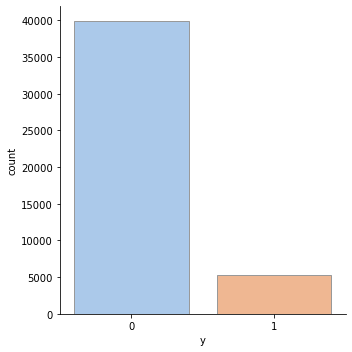

In [9]:
sns.catplot(x = 'y', kind = 'count', palette = 'pastel', edgecolor = '.6', data = df)

### Examine categorical features

#### Unique values
- There're some binary variables such as 'default', 'housing', 'loan'. We might want to transform it for better predicting
- Although no NULL is detected, there are many 'unknown' values, providing no useful information about the client

In [10]:
for col in cate_inputs:
    print('Unique "{}":\n {}'.format(col, df[col].unique()))

Unique "job":
 ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
Unique "marital":
 ['married' 'single' 'divorced']
Unique "education":
 ['tertiary' 'secondary' 'unknown' 'primary']
Unique "default":
 ['no' 'yes']
Unique "housing":
 ['yes' 'no']
Unique "loan":
 ['no' 'yes']
Unique "contact":
 ['unknown' 'cellular' 'telephone']
Unique "month":
 ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
Unique "poutcome":
 ['unknown' 'failure' 'other' 'success']


#### Job
- The average 'y' for each job are all < 0.3
- Retired clients and students are more likely to subscribe among all the jobs

<AxesSubplot:xlabel='job'>

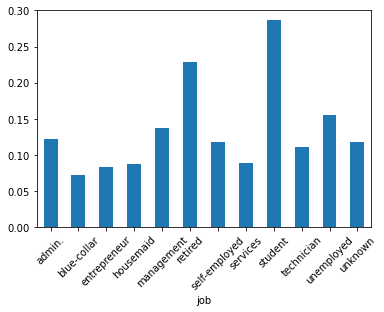

In [11]:
df.groupby('job').mean()['y'].plot.bar(rot=45)

#### Martial
- Single clients are a little bit more likely to subscribe

<AxesSubplot:xlabel='marital'>

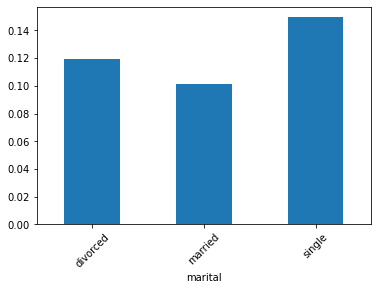

In [12]:
df.groupby('marital').mean()['y'].plot.bar(rot=45)

#### Education
- Clients with higher education level are more likely to subscribe.

<AxesSubplot:xlabel='education'>

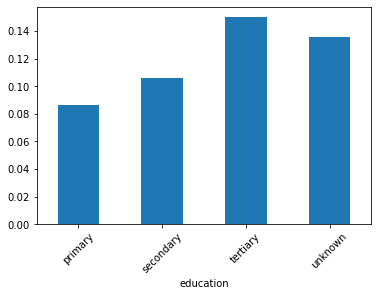

In [13]:
df.groupby('education').mean()['y'].plot.bar(rot=45)

#### Default
- Clients without credit in default are more likely to subscribe

<AxesSubplot:xlabel='default'>

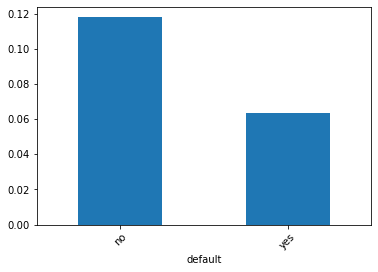

In [14]:
df.groupby('default').mean()['y'].plot.bar(rot=45)

#### Housing
- With housing loan, clients are less likey to subscribe

<AxesSubplot:xlabel='housing'>

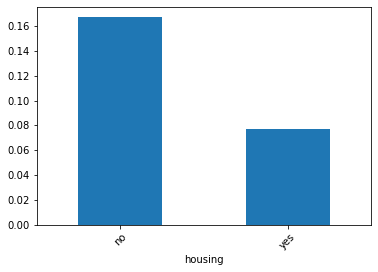

In [15]:
df.groupby('housing').mean()['y'].plot.bar(rot=45)

#### Loan
- Clients with personal loan are less likely to subscribe

<AxesSubplot:xlabel='loan'>

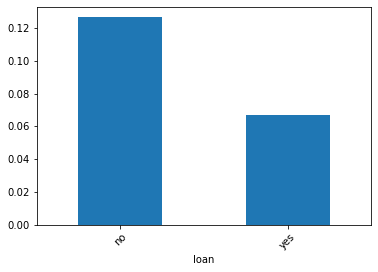

In [16]:
df.groupby('loan').mean()['y'].plot.bar(rot=45)

#### Contact
- The cellular and telephone contact have similar subscribing probability, but the prob of unknown is significantly lower

<AxesSubplot:xlabel='contact'>

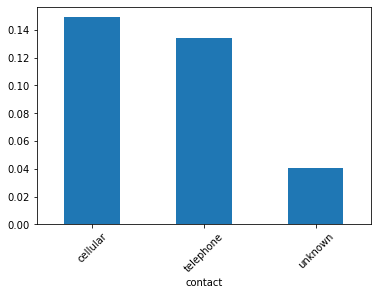

In [17]:
df.groupby('contact').mean()['y'].plot.bar(rot=45)

### Look into numerical features

#### Age
- Majority (that's say 97pp or more) is <= 60
- Among those with age <= 60, the younger the clients are, the more likely that they are to subscribe

<AxesSubplot:xlabel='age', ylabel='Count'>

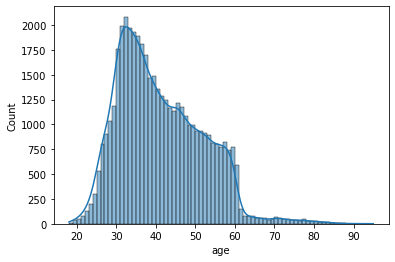

In [18]:
sns.histplot(df['age'], bins=len(df['age'].unique()), kde=True)

<AxesSubplot:xlabel='age'>

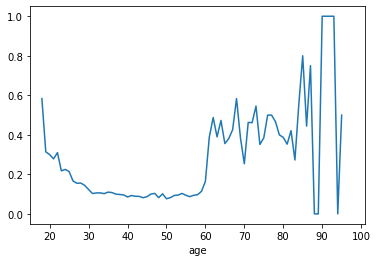

In [19]:
df.groupby('age').mean()['y'].plot(xlim=(15,101))

#### Balance
- Clients with negative balance seems to be less likely to subscribe

<AxesSubplot:xlabel='balance', ylabel='Count'>

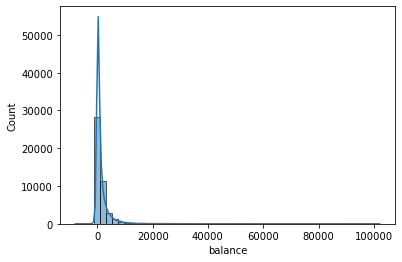

In [20]:
sns.histplot(df['balance'], bins=50, kde=True)

In [21]:
# quantiles of 'balance'
print(df.balance.quantile(.05))
print(df.balance.quantile(.95))

-172.0
5768.0


<AxesSubplot:xlabel='balance'>

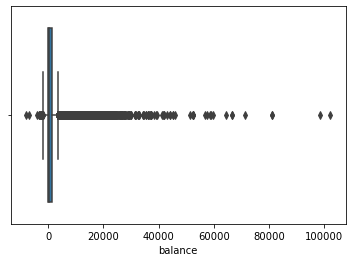

In [22]:
sns.boxplot(x=df.balance)

- Learn from the distribution as well as the boxplot results, 'balance' has many outliers
- So we try to limit the range and check balance again

In [23]:
# based on the 5% and 95% quantiles
df_balance_ranged = df[(df['balance'] < 6000) & (df['balance'] > -200)]

<AxesSubplot:xlabel='balance', ylabel='Count'>

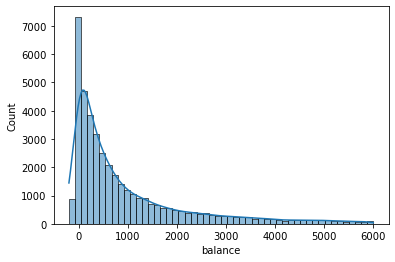

In [24]:
sns.histplot(df_balance_ranged.balance, bins=50, kde=True)

<AxesSubplot:xlabel='balance'>

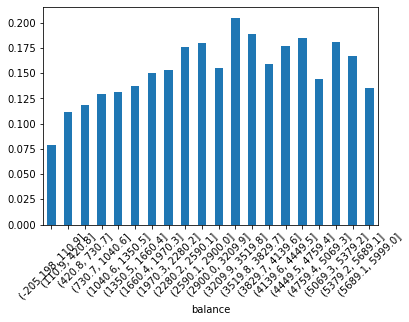

In [25]:
df_balance_ranged.groupby(pd.cut(df_balance_ranged['balance'], bins=20)).mean()['y'].plot.bar(rot=45)

#### Duration
- Client with longer last contact duration are more likely to subscribe
- Notice that we use duration / 60 for plotting because it's in minute which is more understandable

<AxesSubplot:xlabel='duration', ylabel='Count'>

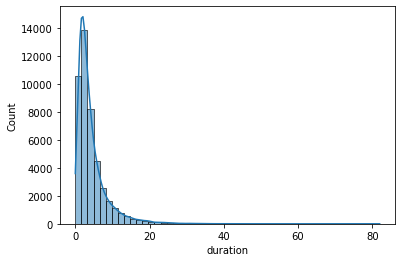

In [26]:
sns.histplot(df.duration / 60, bins=50, kde=True)

- still many outliers

<AxesSubplot:xlabel='duration'>

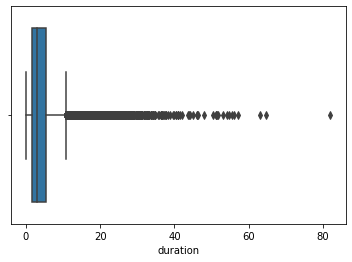

In [27]:
sns.boxplot(x=df.duration / 60)

- shown by the boxplot above, duration in min above 10~15 are regarded as outliers
- then we further check those below 15
- the below bar chart shows an increasing subscription probability of clients with longer contact duration

<AxesSubplot:xlabel='duration'>

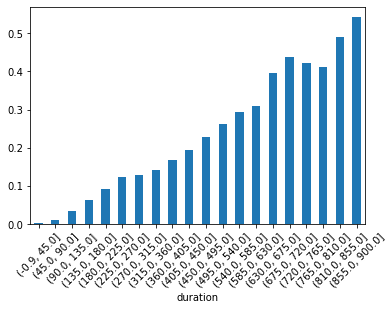

In [28]:
df_duration_ranged = df[df['duration'] /60 <= 15]
df_duration_ranged.groupby(pd.cut(df_duration_ranged['duration'], bins=20)).mean()['y'].plot.bar(rot=45)

#### Campaign
- most clients only have 1 contact during this campaign

<AxesSubplot:xlabel='campaign', ylabel='Count'>

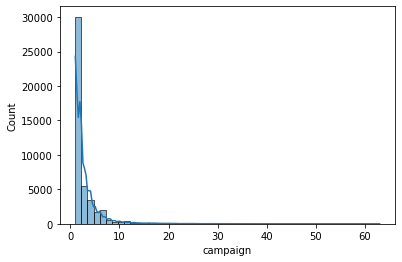

In [29]:
sns.histplot(df.campaign, bins=50, kde=True)

In [30]:
df.groupby('campaign').count()['y']

campaign
1     17544
2     12505
3      5521
4      3522
5      1764
6      1291
7       735
8       540
9       327
10      266
11      201
12      155
13      133
14       93
15       84
16       79
17       69
18       51
19       44
20       43
21       35
22       23
23       22
24       20
25       22
26       13
27       10
28       16
29       16
30        8
31       12
32        9
33        6
34        5
35        4
36        4
37        2
38        3
39        1
41        2
43        3
44        1
46        1
50        2
51        1
55        1
58        1
63        1
Name: y, dtype: int64

In [31]:
print(df.campaign.quantile(.95))
print(df.campaign.quantile(.99))

8.0
16.0


- as 'campaign' > 13 don't have enough samples, we just take those <= 13 for deep diving
- during this campaign, there's a trend that clients being contacted more are less and less likely to subscribe 

<AxesSubplot:xlabel='campaign'>

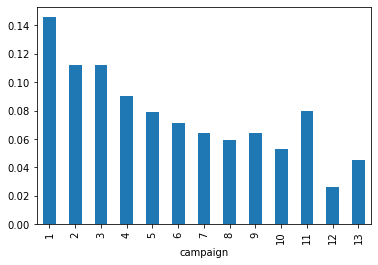

In [32]:
df[df['campaign'] <= 13].groupby('campaign').mean()['y'].plot.bar()

#### Pdays
- The majority of users did not have a last campaign

<AxesSubplot:xlabel='pdays', ylabel='Count'>

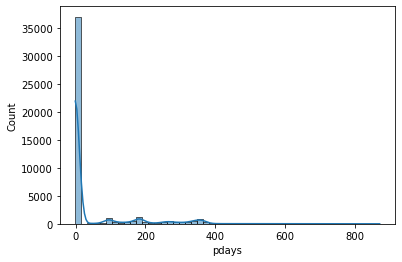

In [33]:
sns.histplot(df.pdays, bins=50, kde=True)

<AxesSubplot:xlabel='pdays', ylabel='Count'>

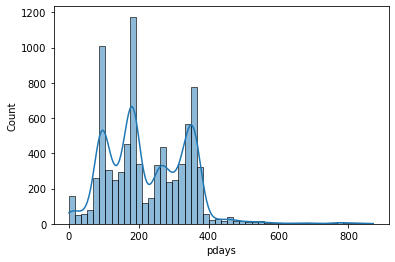

In [34]:
sns.histplot(df[df.pdays > -1].pdays, bins=50, kde=True)

#### Previous
- distribution of 'previous' is also extremly skewed
- For the previous <= 10, clients with more previous campaigns are more likely to subscribe
- only few clients have previous campaigns > 10 (less than 1pp of the sample)

<AxesSubplot:xlabel='previous', ylabel='Count'>

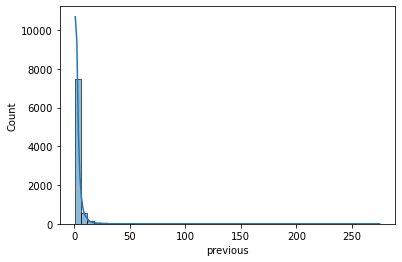

In [35]:
sns.histplot(df[df.previous > 0].previous, bins=50, kde=True)

In [36]:
print(df.previous.quantile(0.95))
print(df.previous.quantile(0.976))
print(df.previous.quantile(0.99))
print(df.previous.quantile(0.999))

3.0
5.0
8.900000000001455
22.0


<AxesSubplot:xlabel='previous', ylabel='Count'>

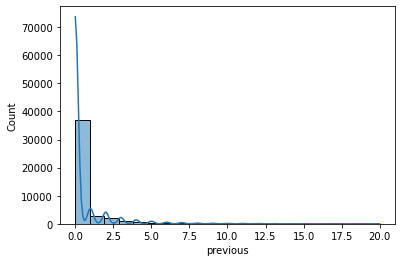

In [37]:
sns.histplot(df.loc[df.previous <= 20, 'previous'], 
             bins=len(df.loc[df.previous <= 20, 'previous'].unique()), kde=True)

<AxesSubplot:xlabel='previous'>

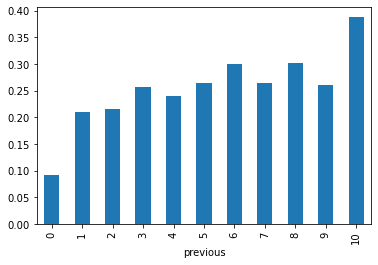

In [38]:
df[df['previous'] <= 10].groupby('previous').mean()['y'].plot.bar()

#### Month
- No clear correlation was found between month and customer subscription

<AxesSubplot:>

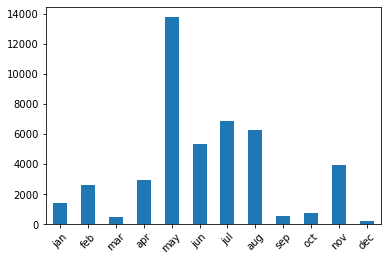

In [39]:
df['month'].value_counts().loc[list(map(lambda x: x.lower(), month_abbr))[1:]].plot.bar(rot=45)

<AxesSubplot:xlabel='month'>

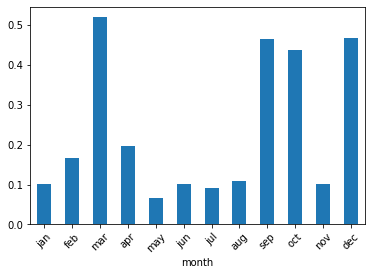

In [40]:
df.groupby('month').mean().loc[list(map(lambda x: x.lower(), month_abbr))[1:], 'y'].plot.bar(rot=45)

#### Day
- No correlation was found between day and customer subscription

<AxesSubplot:xlabel='day', ylabel='Count'>

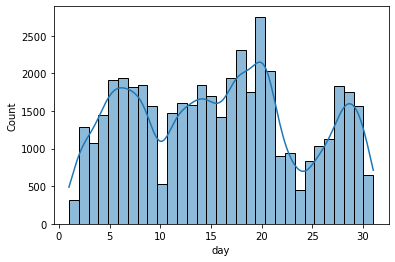

In [41]:
sns.histplot(df.day, bins=len(df['day'].unique()), kde=True)

<AxesSubplot:xlabel='day'>

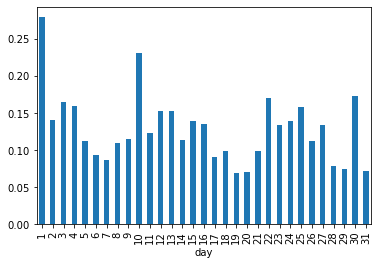

In [42]:
df.groupby('day').mean()['y'].plot.bar()

#### Correlation
- pdays & previous are correlated, while the rest are not considered correlated with each other.

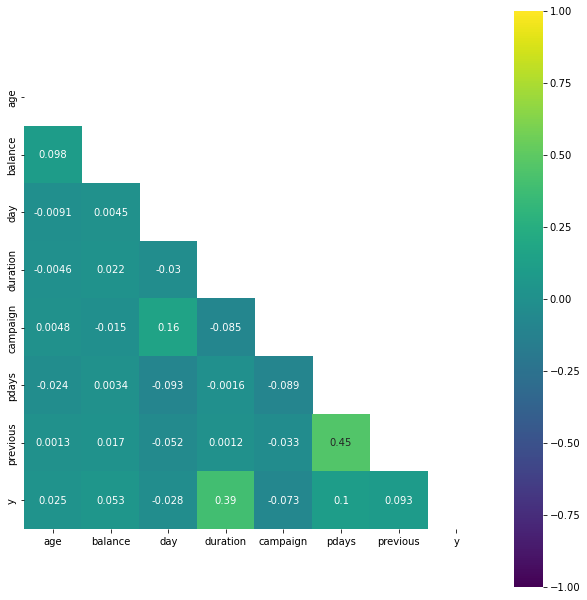

In [43]:
fig= plt.figure(figsize=(8,8))

corr = df.dropna().corr()
mask = np.triu(df.corr())

axes = fig.add_axes([0, 0, 1, 1])
sns.heatmap(corr, annot=True, mask=mask, square=True,fmt='.2g',vmin=-1, vmax=1, center= 0, cmap='viridis',
            linecolor='white', cbar_kws= {'orientation': 'vertical'}, ax=axes)

## 2. Preprocessing

### Process binary variables
- {"yes": 1, "no", 0}

In [44]:
mapping_yn = {'no': 0, 'yes': 1}
col_binary = ['default', 'housing', 'loan']
for col in col_binary:
    df[col] = df[col].map(mapping_yn)

### Unknown
- From the very first look, we know that 'job', 'education', 'contact', 'poutcome' have 'unknown' value.
- There are a large percentage of unknown previous outcomes, which is not surprising because many customers don't have previous contacts (previous=0).

In [45]:
col_unknwn = ['job', 'education', 'contact', 'poutcome']
for col in col_unknwn:
    pp = round(df[df[col]=='unknown'][col].count()/df[col].count() * 100,1)
    print('Unknown of {}: {}pp'.format(col, pp))

Unknown of job: 0.6pp
Unknown of education: 4.1pp
Unknown of contact: 28.8pp
Unknown of poutcome: 81.7pp


### Month
- from string to numbers

In [46]:
mapping_month = dict((month.lower(), number) for number, month in enumerate(month_abbr))
df['month'] = df['month'].map(mapping_month)

In [47]:
df.month.unique().sort()

### One-hot encoding
- exclude month (has been mapped into numerical) and those binary ones

In [48]:
cols_dumm = ['job', 'marital', 'contact', 'poutcome', 'education']
df = pd.get_dummies(df, columns=cols_dumm)

In [49]:
# Remove the columns corresponding to unknown value
cols_onehot_unknown = [col for col in df.columns if 'unknown' in col]
df = df.drop(cols_onehot_unknown, axis=1)

In [50]:
df.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'month',
       'duration', 'campaign', 'pdays', 'previous', 'y', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'contact_cellular',
       'contact_telephone', 'poutcome_failure', 'poutcome_other',
       'poutcome_success', 'education_primary', 'education_secondary',
       'education_tertiary'],
      dtype='object')

In [51]:
col_features = list(df.columns)
col_features.remove('y')
col_target = 'y'

In [52]:
pd.set_option('display.max_columns', None)
df.head(3)

,age,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,poutcome_failure,poutcome_other,poutcome_success,education_primary,education_secondary,education_tertiary
0,58,0,2143,1,0,5,5,261,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,44,0,29,1,0,5,5,151,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
2,33,0,2,1,1,5,5,76,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


### Train Test Split

In [53]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1012, stratify=df[col_target])

In [54]:
X_train, y_train = df_train[col_features], df_train[col_target]
X_test, y_test = df_test[col_features], df_test[col_target]

In [55]:
print('Input size:')
print(f'Training Set: {X_train.shape}')
print(f'Test Set: {X_test.shape}')

Input size:
Training Set: (36168, 33)
Test Set: (9043, 33)


In [56]:
print('Output size:')
print(f'Training Set: {y_train.shape}')
print(f'Test Set: {y_test.shape}')

Output size:
Training Set: (36168,)
Test Set: (9043,)


### Standardize

In [57]:
scaler = MinMaxScaler()

In [58]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Oversampling

In [59]:
sm = SMOTE(random_state=1012)

In [60]:
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

### Input Correlation
- Find if the input features have a strong correlation with each other
- Only features regarding previous campaign are highly correlated because most people does not have a previous previous campaign

<AxesSubplot:>

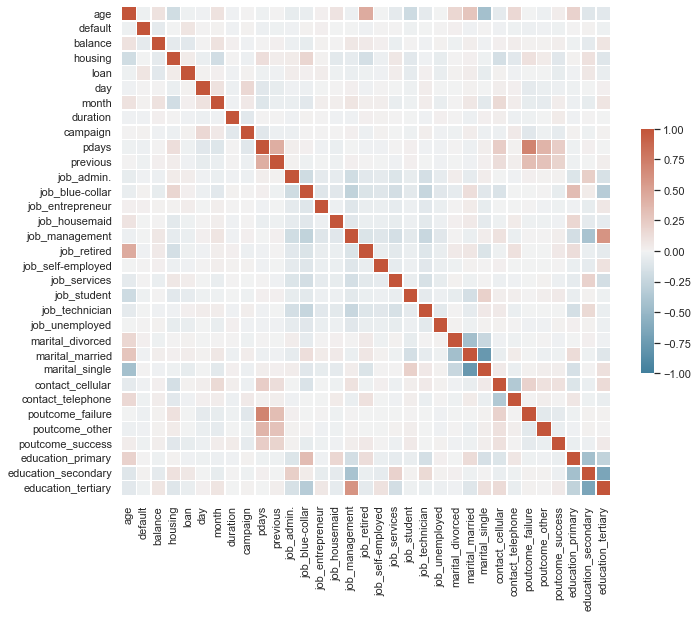

In [61]:
sns.set_theme(style="white")

# Compute the correlation matrix with pearson
corr = X_train.corr(method='pearson')

# Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## 3. Modeling
- there're 3 preprocessed data ready to use
1. X_train, X_test: only after basic transformation
2. X_train_scaled, X_test_scaled: transform + standardize
3. X_train_sm, X_test_sm: transform + oversampling

### Logistic Regression

In [62]:
# Make a MCC Scorer for GridSearchCV Hyper-parameter tuning
MCC_scorer = make_scorer(matthews_corrcoef)

In [63]:
params_logistic = {'C': [0.1, 0.5, 1, 5, 10, 20, 40, 70, 100, 300, 500]}
clf_logistic = GridSearchCV(LogisticRegression(tol=1e-4, max_iter=10000, class_weight='balanced'), 
                            params_logistic, cv=5, scoring=MCC_scorer)

In [64]:
clf_logistic.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000),
             param_grid={'C': [0.1, 0.5, 1, 5, 10, 20, 40, 70, 100, 300, 500]},
             scoring=make_scorer(matthews_corrcoef))

In [65]:
clf_logistic.best_params_

{'C': 70}

In [66]:
# Best cross validation score
clf_logistic.best_score_

0.47729894531109884

In [67]:
pd.DataFrame({'feature': col_features, 'coef': clf_logistic.best_estimator_.coef_[0]})

,feature,coef
0,age,0.114245
1,default,-0.330517
2,balance,3.312875
3,housing,-0.912837
4,loan,-0.703627
5,day,-0.241942
6,month,-0.393640
7,duration,27.025697
8,campaign,-7.112243
9,pdays,-0.307934


In [68]:
pred_logistic = clf_logistic.predict(X_test_scaled)

In [69]:
print(classification_report(y_test, pred_logistic))

              precision    recall  f1-score   support

           0       0.97      0.83      0.89      7985
           1       0.38      0.79      0.51      1058

    accuracy                           0.83      9043
   macro avg       0.67      0.81      0.70      9043
weighted avg       0.90      0.83      0.85      9043



In [70]:
mcc_logistic = matthews_corrcoef(y_test, pred_logistic)
print(f'MCC of Logistic Regression: {mcc_logistic:.4f}')

MCC of Logistic Regression: 0.4658


### Ridge Classifier

In [71]:
params_ridge = {'alpha': [ 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01]}
clf_ridge = GridSearchCV(RidgeClassifier(tol=1e-4, class_weight='balanced'), 
                         params_ridge, cv=5, scoring=MCC_scorer)

In [72]:
clf_ridge.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=RidgeClassifier(class_weight='balanced', tol=0.0001),
             param_grid={'alpha': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1]},
             scoring=make_scorer(matthews_corrcoef))

In [73]:
clf_ridge.best_params_

{'alpha': 0.1}

In [74]:
# Best cross validation score
clf_ridge.best_score_

0.4770972004492517

In [75]:
pred_ridge = clf_ridge.predict(X_test_scaled)

In [76]:
print(classification_report(y_test, pred_ridge))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90      7985
           1       0.39      0.75      0.52      1058

    accuracy                           0.84      9043
   macro avg       0.68      0.80      0.71      9043
weighted avg       0.90      0.84      0.86      9043



In [77]:
mcc_ridge = matthews_corrcoef(y_test, pred_ridge)
print(f'MCC of Ridge Classifier: {mcc_ridge:.4f}')

MCC of Ridge Classifier: 0.4619


### Naive Bayes

In [78]:
params_nb = {'priors':[None], 'var_smoothing':[1e-09]}
clf_nb = GridSearchCV(GaussianNB(), params_nb, cv=5, scoring=MCC_scorer)
clf_nb.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'priors': [None], 'var_smoothing': [1e-09]},
             scoring=make_scorer(matthews_corrcoef))

In [79]:
clf_nb.best_params_

{'priors': None, 'var_smoothing': 1e-09}

In [80]:
# Best cross validation score
clf_nb.best_score_

0.3396245271966751

In [81]:
pred_nb = clf_nb.predict(X_test_scaled)

In [82]:
print(classification_report(y_test, pred_nb))

              precision    recall  f1-score   support

           0       0.93      0.88      0.91      7985
           1       0.38      0.53      0.44      1058

    accuracy                           0.84      9043
   macro avg       0.65      0.71      0.67      9043
weighted avg       0.87      0.84      0.85      9043



In [83]:
mcc_nb = matthews_corrcoef(y_test, pred_nb)
print(f'MCC of Naive Bayes: {mcc_nb:.4f}')

MCC of Naive Bayes: 0.3564


### Random Forest

In [84]:
params_rf = {'n_estimators': [200, 300, 500], 
             'criterion': ['gini', 'entropy'], 
             'max_depth': [3, 4, 5], 
             'max_samples': [0.8, None]}
clf_rf = GridSearchCV(RandomForestClassifier(random_state=1012, class_weight='balanced'),
                      params_rf, cv=5, n_jobs=-1, scoring=MCC_scorer)

In [85]:
clf_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=1012),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5], 'max_samples': [0.8, None],
                         'n_estimators': [200, 300, 500]},
             scoring=make_scorer(matthews_corrcoef))

In [86]:
clf_rf.best_params_

{'criterion': 'gini', 'max_depth': 5, 'max_samples': None, 'n_estimators': 500}

In [87]:
# Best cross validation score
clf_rf.best_score_

0.4777452766370283

In [88]:
pred_rf = clf_rf.predict(X_test)

In [89]:
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.98      0.81      0.88      7985
           1       0.37      0.85      0.51      1058

    accuracy                           0.81      9043
   macro avg       0.67      0.83      0.70      9043
weighted avg       0.91      0.81      0.84      9043



In [90]:
mcc_rf = matthews_corrcoef(y_test, pred_rf)
print(f'MCC of Random Forest: {mcc_rf:.4f}')

MCC of Random Forest: 0.4768


### Grandient Boosting

In [101]:
params_gb = {'subsample': [0.8, 1.0],
             'max_depth': [3, 4]}
clf_gb = GridSearchCV(GradientBoostingClassifier(n_estimators=300, learning_rate=0.1,
                                                 random_state=42),
                      params_gb, cv=5, n_jobs=-1, scoring=MCC_scorer)

In [102]:
clf_gb.fit(X_train_sm, y_train_sm)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(n_estimators=300,
                                                  random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 4], 'subsample': [0.8, 1.0]},
             scoring=make_scorer(matthews_corrcoef))

In [103]:
clf_gb.best_params_

{'max_depth': 4, 'subsample': 0.8}

In [104]:
# Best cross validation score
clf_gb.best_score_

0.8460733161124369

In [105]:
pred_gb = clf_gb.predict(X_test)

In [106]:
print(classification_report(y_test, pred_gb))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      7985
           1       0.58      0.53      0.55      1058

    accuracy                           0.90      9043
   macro avg       0.76      0.74      0.75      9043
weighted avg       0.90      0.90      0.90      9043



In [107]:
mcc_gb = matthews_corrcoef(y_test, pred_gb)
print(f'MCC of Gradient Boosting: {mcc_gb:.4f}')

MCC of Gradient Boosting: 0.4959


In [108]:
# Get the feature importance from grandient boosting classifier
pd.DataFrame({'feature': col_features, 'importance': clf_gb.best_estimator_.feature_importances_})\
    .sort_values('importance', ascending=False).reset_index(drop=True)

,feature,importance
0,duration,0.371379
1,housing,0.142118
2,pdays,0.067078
3,marital_divorced,0.041051
4,marital_married,0.036791
5,month,0.034902
6,education_primary,0.032440
7,marital_single,0.028967
8,loan,0.022108
9,poutcome_failure,0.021596


## 4. Summary
- Using different methods to compare the performance of above algorithms
- Among all the algorithms, Gradient Boosting is the best algorithm with highest ROC AUC and MCC value.

### ROC Curve

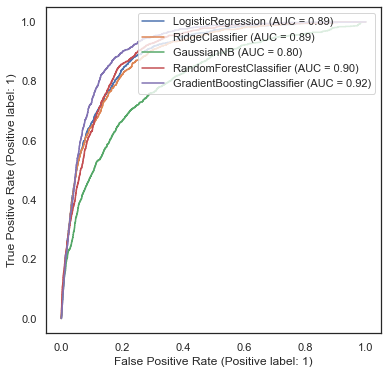

In [109]:
f, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(clf_logistic.best_estimator_, X_test_scaled, y_test, pos_label=1, ax=ax)
plot_roc_curve(clf_ridge.best_estimator_, X_test_scaled, y_test, pos_label=1, ax=ax)
plot_roc_curve(clf_nb.best_estimator_, X_test_scaled, y_test, pos_label=1, ax=ax)
plot_roc_curve(clf_rf.best_estimator_, X_test, y_test, pos_label=1, ax=ax)
plot_roc_curve(clf_gb.best_estimator_, X_test, y_test, pos_label=1, ax=ax)
plt.legend(loc=1)
plt.show()

### MCC

In [110]:
classifier_names = ['Logistic Regression', 'Ridge Classifier', 'Naive Bayes', 
                    'Random Forest', 'Gradient Boosting']
MCC_scores = [mcc_logistic, mcc_ridge, mcc_nb, mcc_rf, mcc_gb]
pd.DataFrame({'Classifier': classifier_names, 'MCC Score': MCC_scores})\
            .sort_values('MCC Score', ascending=False).reset_index(drop=True)

,Classifier,MCC Score
0,Gradient Boosting,0.495904
1,Random Forest,0.476801
2,Logistic Regression,0.465758
3,Ridge Classifier,0.461945
4,Naive Bayes,0.356444
